# Convert and test Matthew's python exposure code


In [28]:
%matplotlib inline
from importlib import reload
import glob
from astropy.io import fits
from astropy.coordinates import SkyCoord
import exposure as exp; reload(exp)

<module 'exposure' from '/nfs/farm/g/glast/u/burnett/analysis/agn_timing/code/exposure.py'>

### Locate files used for catalog
Note that the data files are not FT1 but binned: code here uses only for GTI data

In [29]:
yearly_ft2files = sorted(glob.glob('/nfs/farm/g/glast/g/catalog/P8_P305/ft2_20*.fits'))
yearly_datafiles= sorted(glob.glob(os.path.expandvars('$FERMI/data/P8_P305/yearly/*.fits')))
# select the first 5 months
ft2= yearly_ft2files[0]
ft1= yearly_datafiles[0]

In [30]:
sc=SkyCoord.from_name('Vela pulsar') ;sc#"PSR J1012+5307")

<SkyCoord (ICRS): (ra, dec) in deg
    (128.83606354, -45.17643181)>

### Try Matthew's suggested procedure

In [31]:
lt = exp.Livetime(ft2, ft1, )

Processing GTI...
Processed 5497 intervals with 25801634 s live time
Loading FT2 files /nfs/farm/g/glast/g/catalog/P8_P305/ft2_2008.fits
Processing the FT2 file (calculating overlap with GTI)...


In [32]:
edf = lt.get_exposure(sc)

time range: 239562718 to 252478259


In [35]:
edf.head()

,tstart,tstop,exposure
0,239562717.6,239562747.6,35490.317508
1,239562747.6,239562777.6,39597.037695
2,239562777.6,239562807.6,43763.110024
3,239562807.6,239562837.6,48119.185799
4,239562837.6,239562867.6,52462.928277


### Get a data set and add livetime information

In [36]:
dfall = pd.read_pickle('../data/vela.pkl')
times = dfall.time.values
tstart=edf.tstart.values
tstop =edf.tstop.values
print(f'Time data: {len(times):,} events from {times[0]:.0f} to {times[-1]:.0f}')
# find range comvered by current GTI and make subset DataFrame
imin,imax = np.searchsorted(times, [tstart[0],tstop[-1]]);
df = dfall.iloc[imin:imax].copy(); len(df)
print(f'Select {len(df):,} photons within live time range')

# get associated live time index for each photon
lt_index = np.searchsorted(tstop, df.time) # before which stop
df.loc[:,'lt_index']=lt_index
# make sure past start
tdiff = df.time - tstart[df.lt_index]
in_gti = tdiff.values>=0

print(f'... but exclude {sum(~in_gti):,} photons not in GTI')
df=df[in_gti]
df.head()

Time data: 3,950,346 events from 239562775 to 573335078
Select 143,889 photons within live time range
Exclude 1,058 photons not in GTI


,band,time,delta,lt_index
0,0,2.395628e+08,0.387063,1
1,6,2.395628e+08,0.786543,3
2,11,2.395629e+08,0.580463,5
3,5,2.395629e+08,1.918532,6
4,8,2.395629e+08,0.336302,6


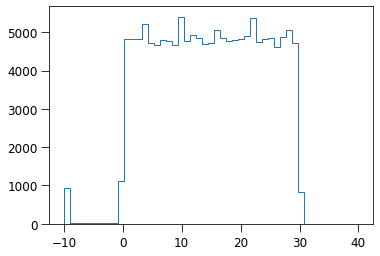

In [37]:
plt.hist(tdiff.clip(-10, 40), np.linspace(-10,40), histtype='step');

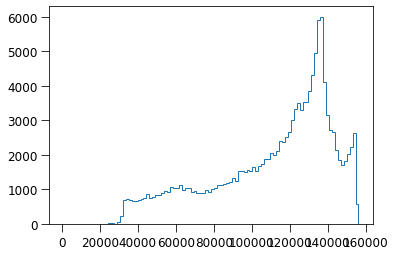

In [39]:
# check that LT intervals found have sensible livetime
plt.hist(edf.exposure[lt_index], bins=100, histtype='step');